In [2]:
import numpy as np
import pandas as pd 
import torch
from glob import glob
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as T
import utils

import os
import pandas as pd
cwd = os.getcwd()

In [3]:
def save_results(name, train_loss, val_loss):
    pd.DataFrame(train_loss).to_csv(
        f"{cwd}/results/{name}/{name}_train.txt")
    pd.DataFrame(val_loss).to_csv(
        f"{cwd}/results/{name}/{name}_val.txt")


In [4]:
import matplotlib.pyplot as plt 

def plot_results(name, train_loss, val_loss):
    plt.figure(figsize=(10, 8))
    plt.plot(train_loss,color='b',label='train loss')
    plt.plot(val_loss,color='r',label = 'val_loss')
    plt.legend()
    plt.savefig(f"{cwd}/results/{name}/{name}_graph") 

In [5]:
from model import UNet

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def run(train_data, val_data, name, lr=0.01):
    save_path = f"{cwd}/results/{name}/"
    model = UNet(3).float().to(device)
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_info = utils.train(
        model, train_data, val_data, loss_function, optimizer,
        epochs=30, show_every=5, save_path=f"{save_path}{name}"
    )

    save_results(name, *train_info)
    plot_results(name, *train_info)
    torch.save(model.state_dict(), f"{save_path}model.pt")

In [6]:
IMG_SIZE =256
transformImage = T.Compose([
        T.ToTensor(),
        T.Resize((IMG_SIZE, IMG_SIZE))
    ]
)

ds_kwargs = {
    "transform_orig": transformImage,
    "transform_seg": transformImage,
}

### Cityscapes

In [13]:
DATA_DIR = "/home/will/Documents/datasets/cityscapes-image-pairs/cityscapes_data"

train_path = glob(f'{DATA_DIR}/train/*')
valid_path = glob(f'{DATA_DIR}/val/*')

train_data = utils.AnyDataset(train_path, **ds_kwargs)
val_data = utils.AnyDataset(valid_path, **ds_kwargs)

### Carla

In [7]:
DATA_DIR = "/home/will/Documents/datasets/carla"
images = glob(f'{DATA_DIR}/images/*')
labels = glob(f'{DATA_DIR}/labels/*')

full_dataset = utils.AnyDataset(images, labels, transformImage, transformImage)
split = int(len(full_dataset) * 0.7)
train_data, val_data = torch.utils.data.random_split(
    full_dataset, [split, len(full_dataset) - split])

In [ ]:
run(train_data, val_data, "carla")

In [15]:
model = UNet(3).float().to(device)
model.load_state_dict(
    torch.load(f"{cwd}/results/cityscapes/model.pt"))
model.eval()

UNet(
  (conv1): Convblock(
    (convblock): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (4): ReLU(inplace=True)
    )
  )
  (conv2): Convblock(
    (convblock): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (4): ReLU(inplace=True)
    )
  )
  (conv3): Convblock(
    (convblock): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 

/home/will/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:150: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


0.0034325122833251953


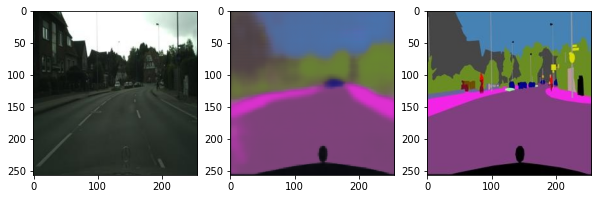

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0041961669921875


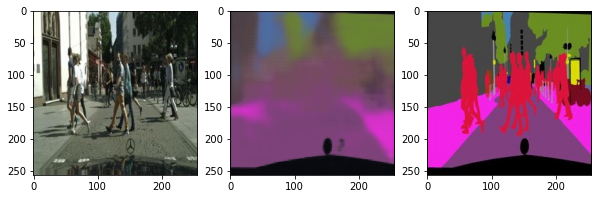

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.003450632095336914


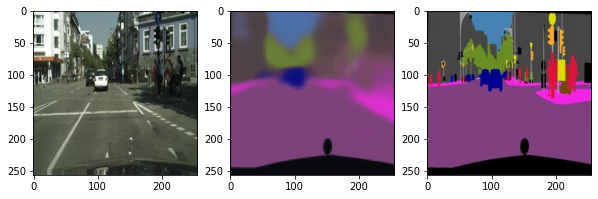

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0021681785583496094


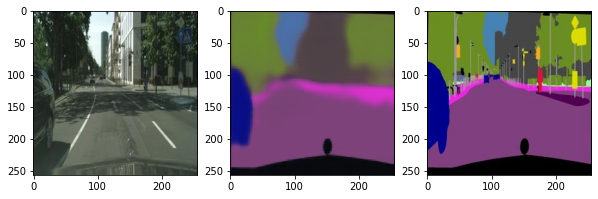

0.002261638641357422


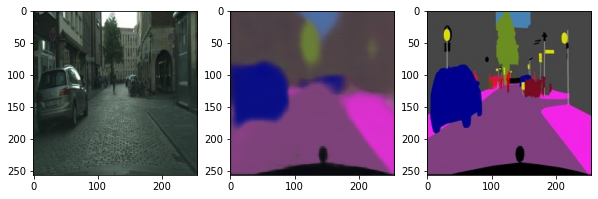

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0030105113983154297


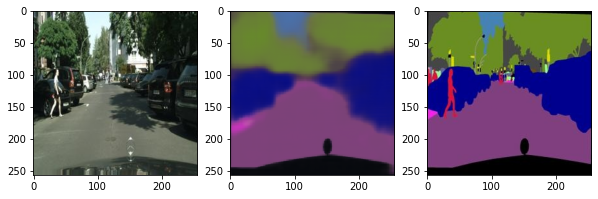

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0033588409423828125


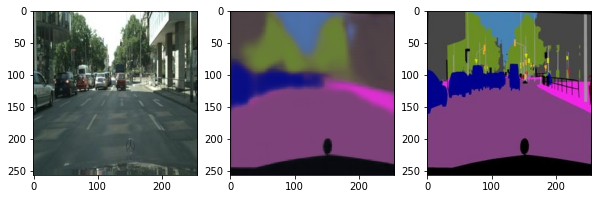

0.0022199153900146484


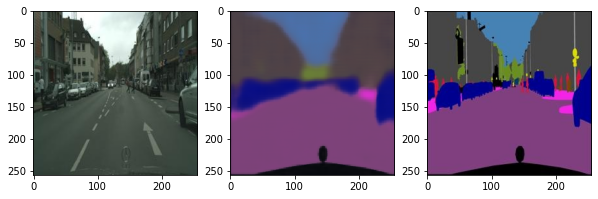

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0023200511932373047


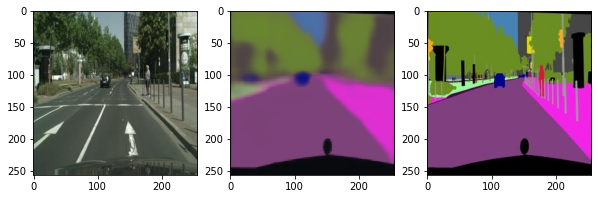

0.0035805702209472656


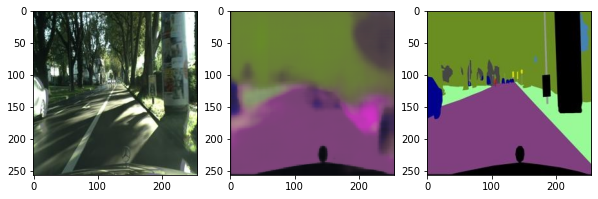

In [16]:
import time
from utils import show
rands = np.random.randint(0, len(val_data), size=10)
inference_time = []

for (img, label) in [val_data[i] for i in rands]:
    img = torch.unsqueeze(img, 0).to(device)
    label = torch.unsqueeze(label, 0).to(device)

    start = time.time()
    pred = model(img)
    stop = time.time()
    inference_time.append(stop - start)
    print(inference_time[-1])

    img = img[0].cpu().permute(1, 2, 0)
    label = label[0].cpu().permute(1, 2, 0)
    pred = pred[0].cpu().detach().permute(
        1, 2, 0).numpy()

    show(img, pred, label)

In [17]:
print(np.array(inference_time).mean())

0.00299990177154541
